In [66]:
import sys
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dropout,Flatten,Dense,Input,AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import numpy as np
import os
import argparse
import cv2

In [47]:
init=1e-4
epochs=20
bs=30

In [48]:
pat=r'G:\face-mask-detector\dataset'
imagepaths=list(paths.list_images(pat))
data=[]
labels=[]
for i in imagepaths:
    label=i.split(os.path.sep)[-2]
    image=load_img(i,target_size=(224,224))
    image=img_to_array(image)
    image=preprocess_input(image)
    data.append(image)
    labels.append(label)

In [49]:
print('{} images have been found'.format(len(imagepaths)))

1376 images have been found


In [50]:
data=np.array(data,dtype='float32')
labels=np.array(labels)

In [51]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

In [59]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=.2,stratify=labels,random_state=42)

In [63]:
aug=ImageDataGenerator(
    rotation_range=20,
    zoom_range=.15,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [67]:
baseModel=MobileNetV2(weights='imagenet',include_top=False, input_tensor=Input(shape=(224,224,3)))

headModel=baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name='Flatten')(headModel)
headModel = Dense(128,activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2,activation='softmax')(headModel)

model=Model(inputs=baseModel.input, outputs=headModel)


In [68]:
for layer in baseModel.layers:
    layer.trainable = False

In [69]:
opt = Adam(lr=init,decay=init/epochs)


In [71]:
model.compile(loss='binary_crossentropy',optimizer=opt, metrics=['accuracy'])

In [72]:
history=model.fit(
    aug.flow(xtrain,ytrain,batch_size=bs),
    steps_per_epoch = len(xtrain)//bs,
    validation_data = (xtest,ytest),
    validation_steps = len(xtest)//bs,
    epochs=epochs
)

Epoch 1/20
36/36 [==============================] - 33s 913ms/step - loss: 0.3709 - accuracy: 0.8393 - val_loss: 0.1013 - val_accuracy: 0.9855
Epoch 2/20
36/36 [==============================] - 34s 938ms/step - loss: 0.1052 - accuracy: 0.9710 - val_loss: 0.0477 - val_accuracy: 0.9891
Epoch 3/20
36/36 [==============================] - 33s 913ms/step - loss: 0.0692 - accuracy: 0.9850 - val_loss: 0.0286 - val_accuracy: 0.9964
Epoch 4/20
36/36 [==============================] - 33s 917ms/step - loss: 0.0533 - accuracy: 0.9822 - val_loss: 0.0204 - val_accuracy: 0.9964
Epoch 5/20
36/36 [==============================] - 34s 940ms/step - loss: 0.0356 - accuracy: 0.9907 - val_loss: 0.0164 - val_accuracy: 1.0000
Epoch 6/20
36/36 [==============================] - 33s 914ms/step - loss: 0.0312 - accuracy: 0.9925 - val_loss: 0.0126 - val_accuracy: 1.0000
Epoch 7/20
36/36 [==============================] - 33s 915ms/step - loss: 0.0342 - accuracy: 0.9869 - val_loss: 0.0109 - val_accuracy: 1.0000

In [73]:
pred = model.predict(xtest,batch_size=bs)

In [74]:
pred=np.argmax(pred,axis=1)

In [77]:
print(classification_report(ytest.argmax(axis=1),pred,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       138
without_mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [80]:
model.save('face_mask')
#reconstructed_model = keras.models.load_model("my_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: face_mask\assets


In [81]:
model.save('face_mask1',save_format='h5')

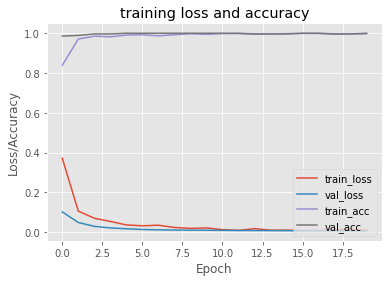

In [88]:
n=epochs
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0,n),history.history['loss'],label='train_loss')
plt.plot(np.arange(0,n),history.history['val_loss'],label='val_loss')
plt.plot(np.arange(0,n),history.history['accuracy'],label='train_acc')
plt.plot(np.arange(0,n),history.history['val_accuracy'],label='val_acc')
plt.title('training loss and accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower right')